In [1]:
# Cell 0 - Environment / config
import os
from pathlib import Path
import random
import warnings
warnings.filterwarnings("ignore")

RANDOM_SEED = 42
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)
random.seed(RANDOM_SEED)

# Paths requested by you
DATA_PATH = Path("/Users/ravigurjar/Desktop/temp/sample/dessertation/data/cleaned/final_df.csv")
RESULT_DIR = Path("/Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep")
RESULT_DIR.mkdir(parents=True, exist_ok=True)

# Training config (tweak if needed)
WINDOW_SIZE = 48          # number of past timesteps used as input (e.g., 48 hours)
HORIZON = 1               # predict 1 step ahead
BATCH_SIZE = 32
EPOCHS = 100
VALIDATION_SPLIT = 0.2    # within training set
VERBOSE = 1

# Device info
print("Data path:", DATA_PATH)
print("Results saved to:", RESULT_DIR)

Data path: /Users/ravigurjar/Desktop/temp/sample/dessertation/data/cleaned/final_df.csv
Results saved to: /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep


In [2]:
# Cell 1 - Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks, models

# set TF seeds for reproducibility (best-effort)
tf.random.set_seed(RANDOM_SEED)

Using target column: latitude
Data shape: (7835, 13)


,timestamp,latitude,longitude,pm25_ugm3,co_ppm,no2_ppb,so2_ppb,o3_ppb,temperature_c,relative_humidity,wind_speed_ms,wind_direction_deg,aqi_value
0,2024-05-01 09:00:00,14.675886,77.593027,75.0,7.2,4.7,3.6,6.8,35.22,33.79,3.94,259.8,75
1,2024-05-01 05:00:00,16.987287,81.736318,5.0,5.8,1.1,4.7,6.5,34.87,52.86,4.19,202.5,19
2,2024-05-01 10:00:00,13.670000,79.350000,90.0,7.3,10.0,4.1,12.5,35.10,46.06,4.31,176.7,90
3,2020-11-19 16:00:00,16.507014,80.627767,52.0,4.2,0.7,4.9,5.1,24.94,87.03,2.44,109.8,-
4,2024-05-01 10:00:00,27.103358,93.679645,127.0,2.8,1.1,1.7,1.0,25.98,66.55,3.14,222.0,127


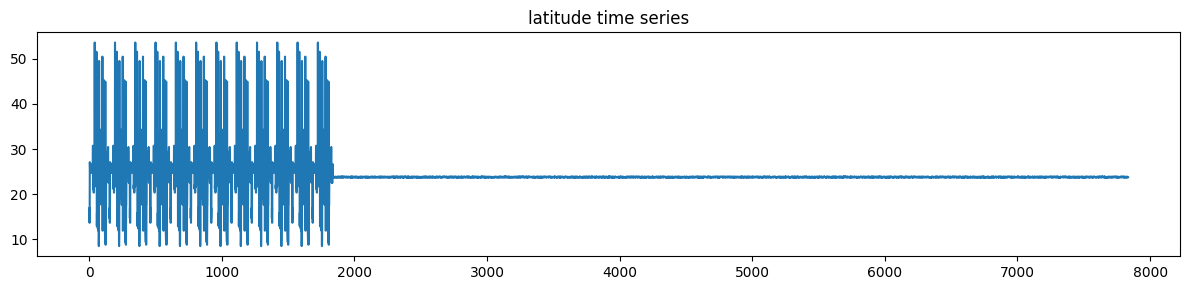

In [3]:
# Cell 2 - Load data & basic EDA
if not DATA_PATH.exists():
    raise FileNotFoundError(f"{DATA_PATH} not found. Put your CSV there or update DATA_PATH.")

df = pd.read_csv(DATA_PATH)
# If there's a date column, set as index
if 'date' in df.columns:
    df['date'] = pd.to_datetime(df['date'])
    df = df.set_index('date').sort_index()

# Ensure numeric AQI column exists: choose first numeric column as target by default
num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
if len(num_cols) == 0:
    raise ValueError("No numeric columns found in CSV. Ensure AQI column is numeric.")
TARGET = num_cols[0]
print("Using target column:", TARGET)
print("Data shape:", df.shape)
display(df.head())
plt.figure(figsize=(12,3))
plt.plot(df.index, df[TARGET])
plt.title(f"{TARGET} time series")
plt.tight_layout()
plt.show()

In [4]:
# Cell 3 - Fill missing values & extract series
series = df[TARGET].ffill().bfill().astype(float)  # ensure float
series = series.rename("y")
series.shape, series.dropna().shape

((7835,), (7835,))

In [5]:
# Cell 4 - Window (sequence) generator
def make_windows(series, window_size=WINDOW_SIZE, horizon=HORIZON, stride=1):
    """
    Convert a 1D pd.Series or array into sliding windows for supervised learning.
    Returns X (num_samples, window_size, 1) and y (num_samples,)
    """
    arr = np.asarray(series).ravel()
    n = len(arr)
    X_list = []
    y_list = []
    for start in range(0, n - window_size - horizon + 1, stride):
        end = start + window_size
        X_list.append(arr[start:end])
        y_list.append(arr[end + horizon - 1])  # horizon=1 => next timestep
    X = np.array(X_list)
    y = np.array(y_list)
    # reshape X to (samples, window_size, 1)
    X = X.reshape((X.shape[0], X.shape[1], 1))
    return X, y

# Quick check
X_sample, y_sample = make_windows(series, window_size=WINDOW_SIZE, horizon=HORIZON)
print("X_sample.shape:", X_sample.shape, "y_sample.shape:", y_sample.shape)

X_sample.shape: (7787, 48, 1) y_sample.shape: (7787,)


In [6]:
# Cell 5 - Train / validation / test split (time-ordered)
def time_series_train_val_test(X, y, test_size=0.2, val_size=0.1):
    """
    Splits by time order: train | val | test
    test_size and val_size are fractions of the full dataset.
    """
    n = len(X)
    test_n = int(n * test_size)
    val_n = int(n * val_size)
    train_end = n - test_n - val_n
    X_train, y_train = X[:train_end], y[:train_end]
    X_val, y_val = X[train_end:train_end + val_n], y[train_end:train_end + val_n]
    X_test, y_test = X[train_end + val_n:], y[train_end + val_n:]
    return X_train, y_train, X_val, y_val, X_test, y_test

# Create windows
X_all, y_all = make_windows(series, window_size=WINDOW_SIZE, horizon=HORIZON)
X_train, y_train, X_val, y_val, X_test, y_test = time_series_train_val_test(X_all, y_all, test_size=0.2, val_size=0.1)

print("Train:", X_train.shape, y_train.shape, "Val:", X_val.shape, y_val.shape, "Test:", X_test.shape, y_test.shape)

Train: (5452, 48, 1) (5452,) Val: (778, 48, 1) (778,) Test: (1557, 48, 1) (1557,)


In [7]:
# Cell 6 - Scale data (fit scaler on training windows only)
# We'll scale per-feature; here feature is the single series value across time.
scaler = StandardScaler()
# Flatten train X to fit scaler and then transform (fit on values, not sequences)
X_train_flat = X_train.reshape(-1, 1)
scaler.fit(X_train_flat)

# function to scale X (and keep shape)
def scale_X(X, scaler_obj):
    s = X.reshape(-1, 1)
    s_scaled = scaler_obj.transform(s)
    return s_scaled.reshape(X.shape)

X_train_s = scale_X(X_train, scaler)
X_val_s = scale_X(X_val, scaler)
X_test_s = scale_X(X_test, scaler)

# Scale targets (y) with same scaler (important) - treat y as 1D
y_scaler = StandardScaler()
y_train_reshaped = y_train.reshape(-1,1)
y_scaler.fit(y_train_reshaped)
y_train_s = y_scaler.transform(y_train.reshape(-1,1)).ravel()
y_val_s = y_scaler.transform(y_val.reshape(-1,1)).ravel()
y_test_s = y_scaler.transform(y_test.reshape(-1,1)).ravel()

# Save scalers
joblib.dump(scaler, RESULT_DIR / "X_scaler.joblib")
joblib.dump(y_scaler, RESULT_DIR / "y_scaler.joblib")
print("Saved scalers to", RESULT_DIR)

Saved scalers to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep


In [8]:
# Cell 7 - Callbacks
es = callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
rlr = callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, verbose=1, min_lr=1e-6)
checkpoint_cb = callbacks.ModelCheckpoint(filepath=str(RESULT_DIR / "best_model_tmp.h5"),
                                          save_best_only=True, monitor='val_loss', verbose=1)

In [9]:
# Cell 8 - Model builders

def build_lstm(window_size=WINDOW_SIZE):
    inp = layers.Input(shape=(window_size, 1))
    x = layers.LSTM(64, return_sequences=True)(inp)
    x = layers.Dropout(0.2)(x)
    x = layers.LSTM(32)(x)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=out, name='LSTM_model')
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_cnn(window_size=WINDOW_SIZE):
    inp = layers.Input(shape=(window_size, 1))
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='causal')(inp)
    x = layers.Conv1D(32, kernel_size=3, activation='relu', padding='causal')(x)
    x = layers.GlobalAveragePooling1D()(x)
    x = layers.Dense(32, activation='relu')(x)
    out = layers.Dense(1)(x)
    model = models.Model(inputs=inp, outputs=out, name='CNN_model')
    model.compile(optimizer='adam', loss='mse', metrics=['mae'])
    return model

def build_transformer(window_size=WINDOW_SIZE, d_model=64, num_heads=4, ff_dim=128):
    """
    Simple Transformer encoder for time series.
    """
    inp = layers.Input(shape=(window_size, 1))
    # project to d_model
    x = layers.Dense(d_model)(inp)
    # positional embedding (learned)
    pos_emb = layers.Embedding(input_dim=window_size, output_dim=d_model)
    positions = tf.range(start=0, limit=window_size, delta=1)
    pos_encoding = pos_emb(positions)
    x = x + pos_encoding
    # Encoder block
    attn_output = layers.MultiHeadAttention(num_heads=num_heads, key_dim=d_model)(x, x)
    attn_output = layers.Dropout(0.1)(attn_output)
    out1 = layers.LayerNormalization(epsilon=1e-6)(x + attn_output)
    ffn = layers.Dense(ff_dim, activation='relu')(out1)
    ffn = layers.Dense(d_model)(ffn)
    ffn = layers.Dropout(0.1)(ffn)
    out2 = layers.LayerNormalization(epsilon=1e-6)(out1 + ffn)
    pooled = layers.GlobalAveragePooling1D()(out2)
    dense = layers.Dense(64, activation='relu')(pooled)
    out = layers.Dense(1)(dense)
    model = models.Model(inputs=inp, outputs=out, name='Transformer_model')
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=1e-3), loss='mse', metrics=['mae'])
    return model

# instantiate to show summary
lstm = build_lstm()
cnn = build_cnn()
transformer = build_transformer()
print(lstm.summary())
print(cnn.summary())
print(transformer.summary())

Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 48, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ (None, 48, 64)         │        16,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 48, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 32)             │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 30,401 (118.75 KB)

 Trainable params: 30,401 (118.75 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "CNN_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 48, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 48, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 48, 32)         │         6,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,521 (29.38 KB)

 Trainable params: 7,521 (29.38 KB)

 Non-trainable params: 0 (0.00 B)

None


Model: "Transformer_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 48, 1)     │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 48, 64)    │        128 │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 48, 64)    │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 48, 64)    │     66,368 │ add[0][0],        │
│ (MultiHeadAttentio… │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 48, 64)    │          0 │ multi_head_atten… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 48, 64)    │          0 │ add[0][0],        │
│                     │                   │            │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 48, 64)    │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 48, 128)   │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 48, 64)    │      8,256 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 48, 64)    │          0 │ dense_6[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 48, 64)    │          0 │ layer_normalizat… │
│                     │                   │            │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 48, 64)    │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 64)        │          0 │ layer_normalizat… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 64)        │      4,160 │ global_average_p… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_8 (Dense)     │ (None, 1)         │         65 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 87,553 (342.00 KB)

 Trainable params: 87,553 (342.00 KB)

 Non-trainable params: 0 (0.00 B)

None


In [10]:
# Cell 9 - Training helper (train, evaluate, save)
def train_and_evaluate(model, model_name, X_tr, y_tr, X_val, y_val, X_te, y_te,
                       batch_size=BATCH_SIZE, epochs=EPOCHS, callbacks_list=[es, rlr, checkpoint_cb]):
    print(f"\n=== Training {model_name} ===")
    history = model.fit(X_tr, y_tr,
                        validation_data=(X_val, y_val),
                        epochs=epochs,
                        batch_size=batch_size,
                        callbacks=callbacks_list,
                        verbose=VERBOSE)
    # load best weights from checkpoint if exists
    best_path = RESULT_DIR / "best_model_tmp.h5"
    if best_path.exists():
        try:
            model.load_weights(str(best_path))
        except Exception:
            pass

    # predictions (scaled -> inverse scale)
    y_pred_s = model.predict(X_te).ravel()
    # inverse scale
    y_pred = y_scaler.inverse_transform(y_pred_s.reshape(-1,1)).ravel()
    y_true = y_te  # original unscaled y_test
    # metrics
    mae = mean_absolute_error(y_true, y_pred)
    rmse = mean_squared_error(y_true, y_pred) ** 0.5
    r2 = r2_score(y_true, y_pred)
    metrics = {'model': model_name, 'MAE': mae, 'RMSE': rmse, 'R2': r2}
    # save model architecture+weights
    model_save_path = RESULT_DIR / f"{model_name}.h5"
    model.save(model_save_path)
    print(f"Saved model to {model_save_path}")
    # save history plot
    hist_df = pd.DataFrame(history.history)
    hist_df.to_csv(RESULT_DIR / f"{model_name}_history.csv", index=False)
    # save predictions
    pred_df = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=pd.RangeIndex(start=0, stop=len(y_true)))
    pred_df.to_csv(RESULT_DIR / f"{model_name}_predictions.csv", index=False)
    return metrics, history, pred_df

In [11]:
# Cell 10 - Train LSTM (scaled data)
lstm = build_lstm()
metrics_lstm, hist_lstm, preds_lstm = train_and_evaluate(lstm, "LSTM", X_train_s, y_train_s, X_val_s, y_val_s, X_test, y_test)
print("LSTM metrics:", metrics_lstm)


=== Training LSTM ===
Epoch 1/100
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.9503 - mae: 0.4159
Epoch 1: val_loss improved from None to 0.00019, saving model to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/best_model_tmp.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.8570 - mae: 0.3740 - val_loss: 1.8791e-04 - val_mae: 0.0116 - learning_rate: 0.0010
Epoch 2/100
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - loss: 0.8399 - mae: 0.3689
Epoch 2: val_loss improved from 0.00019 to 0.00016, saving model to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/best_model_tmp.h5


171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.7904 - mae: 0.3457 - val_loss: 1.6491e-04 - val_mae: 0.0111 - learning_rate: 0.0010
Epoch 3/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.8003 - mae: 0.3530
Epoch 3: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.7534 - mae: 0.3333 - val_loss: 7.5237e-04 - val_mae: 0.0243 - learning_rate: 0.0010
Epoch 4/100
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.7557 - mae: 0.3421
Epoch 4: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - loss: 0.7119 - mae: 0.3216 - val_loss: 9.5865e-04 - val_mae: 0.0282 - learning_rate: 0.0010
Epoch 5/100
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.7240 - mae: 0.3325
Epoch 5: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - loss: 0.6894 - mae: 0.3143 - val_loss: 0.0029 - val_mae: 0.0524 - learning_rate: 0.0010
Epoch 6/100
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - loss: 0.6949 -

Saved model to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/LSTM.h5
LSTM metrics: {'model': 'LSTM', 'MAE': 4.936599288722095, 'RMSE': 4.936942883172147, 'R2': -7197.689250266132}


In [12]:
# Cell 11 - Train CNN
cnn = build_cnn()
metrics_cnn, hist_cnn, preds_cnn = train_and_evaluate(cnn, "CNN", X_train_s, y_train_s, X_val_s, y_val_s, X_test, y_test)
print("CNN metrics:", metrics_cnn)


=== Training CNN ===
Epoch 1/100
146/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 1.0404 - mae: 0.4374
Epoch 1: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9656 - mae: 0.4047 - val_loss: 2.1231e-04 - val_mae: 0.0123 - learning_rate: 0.0010
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9741 - mae: 0.4093
Epoch 2: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9154 - mae: 0.3836 - val_loss: 1.9355e-04 - val_mae: 0.0119 - learning_rate: 0.0010
Epoch 3/100
160/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9381 - mae: 0.3958
Epoch 3: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8840 - mae: 0.3723 - val_loss: 2.2939e-04 - val_mae: 0.0126 - learning_rate: 0.0010
Epoch 4/100
160/171 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.9157 - mae: 0.3873
Epoch 4: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 0.8659 -

Saved model to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/CNN.h5
CNN metrics: {'model': 'CNN', 'MAE': 114.20930721966792, 'RMSE': 114.20933099625267, 'R2': -3852479.029840784}


In [13]:
# Cell 12 - Train Transformer
transformer = build_transformer()
metrics_trans, hist_trans, preds_trans = train_and_evaluate(transformer, "Transformer", X_train_s, y_train_s, X_val_s, y_val_s, X_test, y_test)
print("Transformer metrics:", metrics_trans)


=== Training Transformer ===
Epoch 1/100
168/171 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 1.0293 - mae: 0.4862
Epoch 1: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 5s 18ms/step - loss: 0.9608 - mae: 0.4526 - val_loss: 0.0214 - val_mae: 0.1453 - learning_rate: 0.0010
Epoch 2/100
171/171 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9644 - mae: 0.4663
Epoch 2: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.9132 - mae: 0.4408 - val_loss: 0.0168 - val_mae: 0.1285 - learning_rate: 0.0010
Epoch 3/100
170/171 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - loss: 0.9328 - mae: 0.4603
Epoch 3: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.8828 - mae: 0.4346 - val_loss: 0.0115 - val_mae: 0.1060 - learning_rate: 0.0010
Epoch 4/100
169/171 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - loss: 0.9150 - mae: 0.4500
Epoch 4: val_loss did not improve from 0.00016
171/171 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step - loss: 0.86

Saved model to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/Transformer.h5
Transformer metrics: {'model': 'Transformer', 'MAE': 5.969253679198054, 'RMSE': 5.9695372763358465, 'R2': -10523.914049608153}


In [14]:
# Cell 13 - Save combined metrics & predictions summary
metrics_df = pd.DataFrame([metrics_lstm, metrics_cnn, metrics_trans])
metrics_df.to_csv(RESULT_DIR / "deep_metrics_summary.csv", index=False)
print("Saved metrics summary to", RESULT_DIR / "deep_metrics_summary.csv")

# Combine predictions into one file for comparison
combined_preds = pd.DataFrame(index=pd.RangeIndex(start=0, stop=len(y_test)))
combined_preds['y_true'] = y_test
combined_preds['pred_lstm'] = preds_lstm['y_pred'].values
combined_preds['pred_cnn'] = preds_cnn['y_pred'].values
combined_preds['pred_transformer'] = preds_trans['y_pred'].values
combined_preds.to_csv(RESULT_DIR / "combined_deep_predictions.csv", index=False)
print("Saved combined predictions to", RESULT_DIR / "combined_deep_predictions.csv")

Saved metrics summary to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/deep_metrics_summary.csv
Saved combined predictions to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/combined_deep_predictions.csv


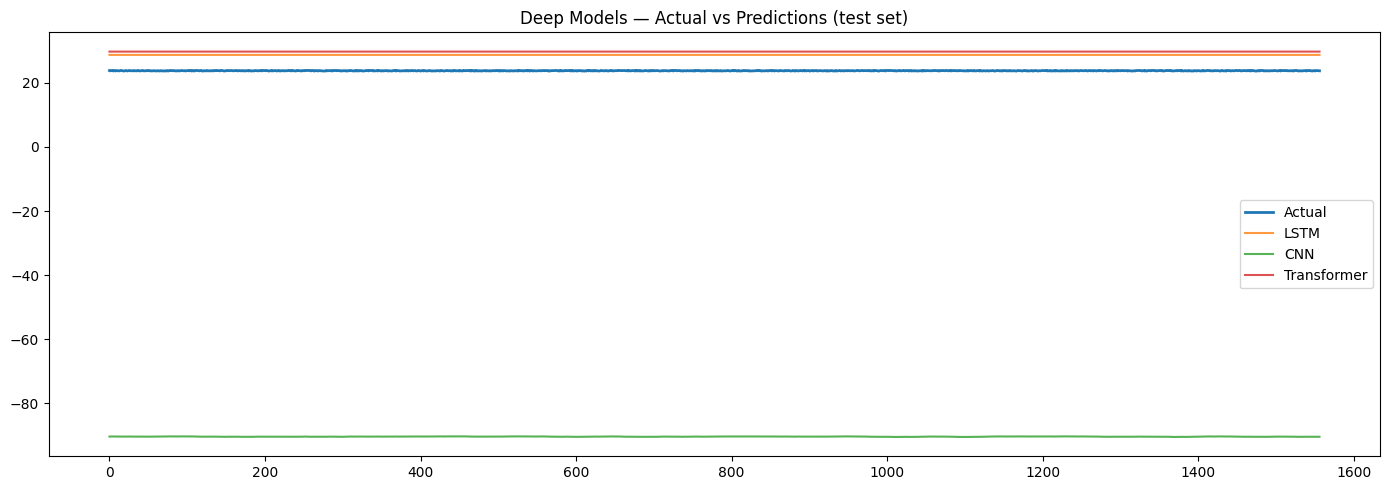

Saved plot to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/deep_models_actual_vs_pred.png


In [15]:
# Cell 14 - Plot actual vs predictions (test set)
plt.figure(figsize=(14,5))
plt.plot(combined_preds['y_true'], label='Actual', linewidth=2)
plt.plot(combined_preds['pred_lstm'], label='LSTM', alpha=0.8)
plt.plot(combined_preds['pred_cnn'], label='CNN', alpha=0.8)
plt.plot(combined_preds['pred_transformer'], label='Transformer', alpha=0.8)
plt.legend()
plt.title("Deep Models — Actual vs Predictions (test set)")
plt.tight_layout()
plt.savefig(RESULT_DIR / "deep_models_actual_vs_pred.png")
plt.show()
print("Saved plot to", RESULT_DIR / "deep_models_actual_vs_pred.png")

In [16]:
# Cell 15 - Quick diagnostics: residuals & error stats
for name, dfp in [("LSTM", preds_lstm), ("CNN", preds_cnn), ("Transformer", preds_trans)]:
    resid = dfp['y_true'] - dfp['y_pred']
    print(f"\n{name} residuals summary:")
    print(resid.describe())
    # save residuals
    dfp.assign(residual=resid).to_csv(RESULT_DIR / f"{name}_predictions_with_residuals.csv", index=False)
print("Saved residuals files")


LSTM residuals summary:
count    1557.000000
mean       -4.936599
std         0.058264
min        -5.039934
25%        -4.987080
50%        -4.936625
75%        -4.885442
max        -4.834879
dtype: float64

CNN residuals summary:
count    1557.000000
mean      114.209307
std         0.073719
min       114.036335
25%       114.154972
50%       114.210541
75%       114.265430
max       114.403461
dtype: float64

Transformer residuals summary:
count    1557.000000
mean       -5.969254
std         0.058206
min        -6.069654
25%        -6.020222
50%        -5.968332
75%        -5.917740
max        -5.869717
dtype: float64
Saved residuals files


In [17]:
# Cell 16 - Save run metadata
meta = {
    'data_path': str(DATA_PATH),
    'result_dir': str(RESULT_DIR),
    'window_size': WINDOW_SIZE,
    'horizon': HORIZON,
    'batch_size': BATCH_SIZE,
    'epochs': EPOCHS,
    'n_train': int(len(X_train)), 'n_val': int(len(X_val)), 'n_test': int(len(X_test)),
    'models': ['LSTM.h5', 'CNN.h5', 'Transformer.h5']
}
pd.Series(meta).to_frame('value').to_csv(RESULT_DIR / "deep_run_metadata.csv")
print("Saved run metadata to", RESULT_DIR / "deep_run_metadata.csv")

Saved run metadata to /Users/ravigurjar/Desktop/temp/sample/dessertation/asset/forcast/deep/deep_run_metadata.csv
